In [19]:
#import processing
from PIL import Image
import os
import pandas as pd
import numpy as np
import skgstat as skg
import matplotlib.pyplot as plt
from matplotlib import colors
import cmocean
from scipy.stats import skew, kurtosis
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import itertools
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

In [2]:
'''
TODO:
1. Standardize file formats?

'''

'\nTODO:\n1. Standardize file formats?\n\n'

In [3]:
sgsdir = "SGS_training_sample/parquet"
dcgandir = "256_dcgan_cp_150/256_dcgan_cp_150"
diffusiondir = "256_sim_cp_10_100_sample.csv"


coord = pd.read_csv("coords_256.csv").values

In [4]:
#SGS - 50 realizations
sgs = np.empty((len(os.listdir(sgsdir)), 256, 256))

for i, name in enumerate(os.listdir(sgsdir)):
    sgs[i] = pd.read_parquet(sgsdir+"/"+name).values.reshape(300,300)[:256, :256]

In [5]:
sgs = (sgs + 1)/2

In [6]:
coord.shape, sgs.shape

((65536, 2), (87, 256, 256))

In [7]:
x_uniq = np.unique(coord[:, 0])
y_uniq = np.unique(coord[:, 1])

xx, yy = np.meshgrid(x_uniq, y_uniq)

xx.shape, yy.shape

((256, 256), (256, 256))

## DCGAN

In [8]:
# DCGAN - 100 samples
dcgan = np.empty((len(os.listdir(dcgandir)), 256, 256))

for i, name in enumerate(os.listdir(dcgandir)):
        path = os.path.join(dcgandir, name)
        image = Image.open(path).convert('L')
        image_normalized = np.array(image, dtype=np.float32) / 255.0
        
        
        dcgan[i] = image_normalized

dcgan.shape

(100, 256, 256)

## Diffusion

In [9]:
# Diffusion - 50 samples (randomly sampled from 100 original -- too big to push to repo!)

diffusion = pd.read_csv(diffusiondir, header = None).iloc[:,1:]
diffusion = diffusion.to_numpy().reshape((diffusion.shape[0], 256, 256))
diffusion.shape

(50, 256, 256)

In [10]:
dmin = -665.37
dmax = 636.33

def rescale_range(x, a, b):
    return a+((x-np.nanmin(x))*(b-a))/(np.nanmax(x)-np.nanmin(x))

sgs = rescale_range(sgs, dmin, dmax)
diffusion = rescale_range(diffusion, dmin, dmax)
dcgan = rescale_range(dcgan, dmin, dmax)

sgs_mean = np.mean(sgs, axis=0)
sgs_var = np.var(sgs, axis=0)
dcgan_mean = np.mean(dcgan, axis=0)
dcgan_var = np.var(dcgan, axis=0)
diff_mean = np.mean(diffusion, axis=0)
diff_var = np.var(diffusion, axis=0)

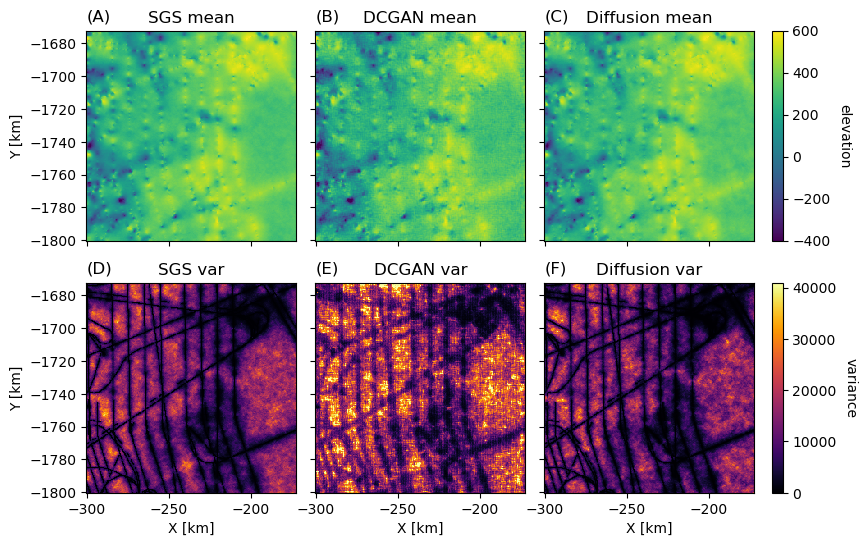

In [37]:
plots = [
    sgs_mean,
    dcgan_mean,
    diff_mean,
    sgs_var,
    dcgan_var,
    diff_var
]

titles = [
    'SGS mean',
    'DCGAN mean',
    'Diffusion mean',
    'SGS var',
    'DCGAN var',
    'Diffusion var'
]

var_vmax = np.max(np.var(sgs, axis=0))

fig = plt.figure(figsize=(9,6))
spec = GridSpec(ncols=4, nrows=2, figure=fig, width_ratios=[1, 1, 1, 0.05], hspace=0.2, wspace=0.1)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[0, 2])
ax4 = fig.add_subplot(spec[1, 0])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[1, 2])
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

for i, (ax, plot, title) in enumerate(zip(axs, plots, titles)):
    if i < 3:
        im1 = ax.pcolormesh(xx/1000, yy/1000, plot, vmin=-400, vmax=600, cmap='viridis')
    else:
        im2 = ax.pcolormesh(xx/1000, yy/1000, plot, vmin=0, vmax=var_vmax, cmap='inferno')
        ax.set_xlabel('X [km]')
    ax.set_title(title)
    ax.axis('scaled')

ax1.set_ylabel('Y [km]')
ax4.set_ylabel('Y [km]')

for ax in [ax1, ax2, ax3]:
    ax.set_xticklabels([])
for ax in [ax2, ax3, ax5, ax6]:
    ax.set_yticklabels([])

cax = fig.add_subplot(spec[0, 3])
cbar = plt.colorbar(im1, cax=cax)
cbar.set_label('elevation', rotation=270, labelpad=15)

cax = fig.add_subplot(spec[1, 3])
cbar = plt.colorbar(im2, cax=cax)
cbar.set_label('variance', rotation=270, labelpad=15)

labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)']

for ax, label in zip([ax1, ax2, ax3, ax4, ax5, ax6], labels):
    ax.text(-0.0, 1.10, label, color='k', fontsize=12, ha='left', va='top', transform=ax.transAxes)

plt.savefig('Plots/mean_var_grid.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Sampling 5 realizations from each model for variogram calculation

random.seed(0)
sgs_sample_index = random.sample(range(sgs.shape[0]), 5)
dcgan_sample_index = random.sample(range(dcgan.shape[0]), 5)
diffusion_sample_index = random.sample(range(diffusion.shape[0]), 5)

In [13]:
# Plotting and variogram params

maxlag = 50000
n_lags = 30
downsample = 0.1

from itertools import cycle
cycol = cycle('bgrcm')

In [14]:
# SGS variograms

sgs_sample = []

for i in sgs_sample_index:
    vario = skg.Variogram(coord, sgs[i].reshape(256**2), bin_func = 'even', n_lags = n_lags, maxlag = maxlag, normalize = True, samples = downsample)
    sgs_sample.append(vario)

In [15]:
#DCGAN variograms

dcgan_sample = []

for i in dcgan_sample_index:
    vario = skg.Variogram(coord, dcgan[i].reshape(256**2), bin_func = 'even', n_lags = n_lags, maxlag = maxlag, normalize = True, samples = downsample)
    dcgan_sample.append(vario)

In [16]:
# Diffusion Variograms

diffusion_sample = []

for i in diffusion_sample_index:
    vario = skg.Variogram(coord, diffusion[i].reshape(256**2), bin_func = 'even', n_lags = n_lags, maxlag = maxlag, normalize = True, samples = downsample)
    diffusion_sample.append(vario)

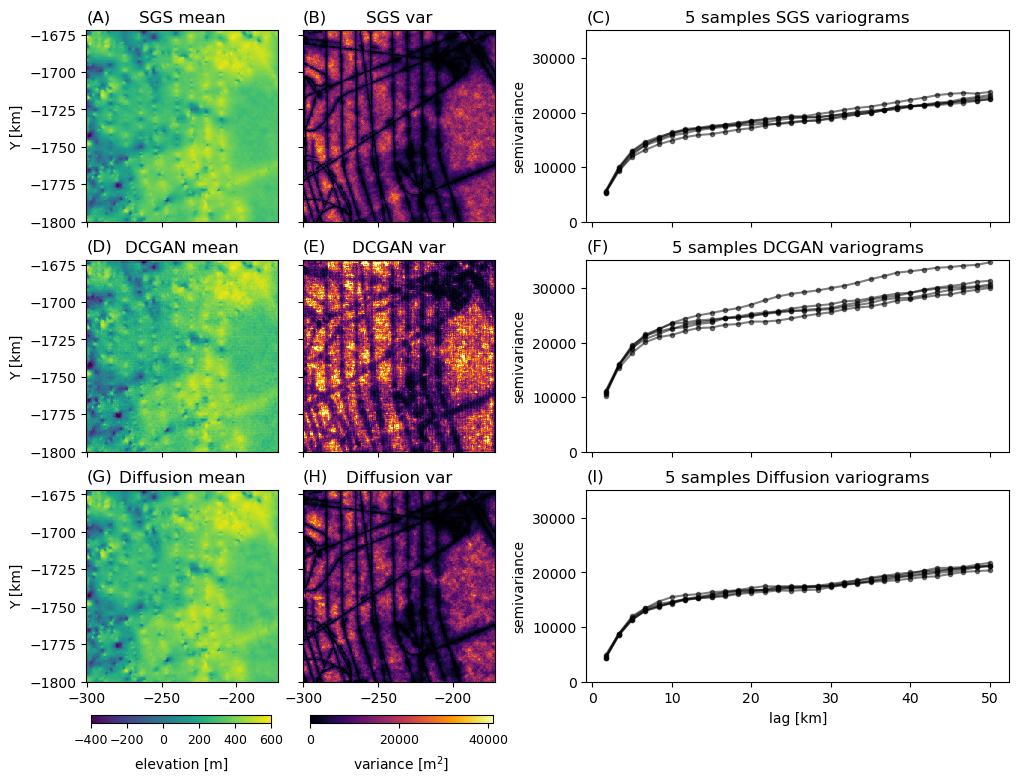

In [38]:
fig = plt.figure(figsize=(12,9))
gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 0.013], hspace=0.1, wspace=0.2)
gs1 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[0,0], wspace=0.05)
gs2 = GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0,1])
#spec = gridspec.GridSpec(ncols=3, nrows=4, figure=fig, width_ratios=[1, 1, 1.5], height_ratios=[1, 1, 1, 0.05], hspace=0.2, wspace=0.1)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs2[0])
ax4 = fig.add_subplot(gs1[1, 0])
ax5 = fig.add_subplot(gs1[1, 1])
ax6 = fig.add_subplot(gs2[1])
ax7 = fig.add_subplot(gs1[2, 0])
ax8 = fig.add_subplot(gs1[2, 1])
ax9 = fig.add_subplot(gs2[2])

axs = [ax1, ax2, ax4, ax5, ax7, ax8]

plots = [
    sgs_mean,
    sgs_var,
    dcgan_mean,
    dcgan_var,
    diff_mean,
    diff_var
]

titles = [
    'SGS mean',
    'SGS var',
    'DCGAN mean',
    'DCGAN var',
    'Diffusion mean',
    'Diffusion var'
]

var_vmax = np.max(np.var(sgs, axis=0))

for i, (ax, plot, title) in enumerate(zip(axs, plots, titles)):
    if i%2==0:
        im1 = ax.pcolormesh(xx/1000, yy/1000, plot, vmin=-400, vmax=600, cmap='viridis')
    else:
        im2 = ax.pcolormesh(xx/1000, yy/1000, plot, vmin=0, vmax=var_vmax, cmap='inferno')
    ax.set_title(title)
    ax.axis('scaled')

for data in sgs_sample:
        ax3.plot(data.bins/1000, data.experimental, '.-', c='k', alpha=0.5)
        ax3.set_title('5 samples SGS variograms')
for data in dcgan_sample:
        ax6.plot(data.bins/1000, data.experimental, '.-', c='k', alpha=0.5)
        ax6.set_title('5 samples DCGAN variograms')
for data in diffusion_sample:
        ax9.plot(data.bins/1000, data.experimental, '.-', c= 'k', alpha=0.5)
        ax9.set_title('5 samples Diffusion variograms')

ax1.set_ylabel('Y [km]')
ax4.set_ylabel('Y [km]')
ax7.set_ylabel('Y [km]')

for ax in [ax3, ax6, ax9]:
    ax.set_ylabel('semivariance')

ax9.set_xlabel('lag [km]')

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xticklabels([])
for ax in [ax2, ax5, ax8]:
    ax.set_yticklabels([])

for ax in [ax3, ax6, ax9]:
    ax.set_ylim([0,35e3])

gs3 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1, 0])
gs4 = GridSpecFromSubplotSpec(1, 64, subplot_spec=gs3[0])
cax = fig.add_subplot(gs4[4:67])
cbar = plt.colorbar(im1, cax=cax, use_gridspec=True, location='bottom', ticks=[-400, -200, 0, 200, 400, 600])
cbar.set_label('elevation [m]', labelpad=8)
cbar.ax.tick_params(labelsize=9)

gs6 = GridSpecFromSubplotSpec(1, 64, subplot_spec=gs3[1])
cax = fig.add_subplot(gs6[0:61])
cbar = plt.colorbar(im2, cax=cax, location ='bottom')
cbar.set_label(r'variance [m$^2$]', labelpad=5)
cbar.ax.tick_params(labelsize=9)

labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)', '(G)', '(H)', '(I)']

for ax, label in zip([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9], labels):
    ax.text(-0.0, 1.11, label, color='k', fontsize=12, ha='left', va='top', transform=ax.transAxes)

plt.savefig('Plots/mean_var_vario_grid.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\mjfie\AppData\Local\Temp\ipykernel_31992\4223468069.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew(sgs, axis=0),
C:\Users\mjfie\AppData\Local\Temp\ipykernel_31992\4223468069.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis(sgs, axis=0),
C:\Users\mjfie\AppData\Local\Temp\ipykernel_31992\4223468069.py:32: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_vmax = np.nanmax(skew(sgs, axis=0))
C:\Users\mjfie\AppData\Local\Temp\ipykernel_31992\4223468069.py:33: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are n

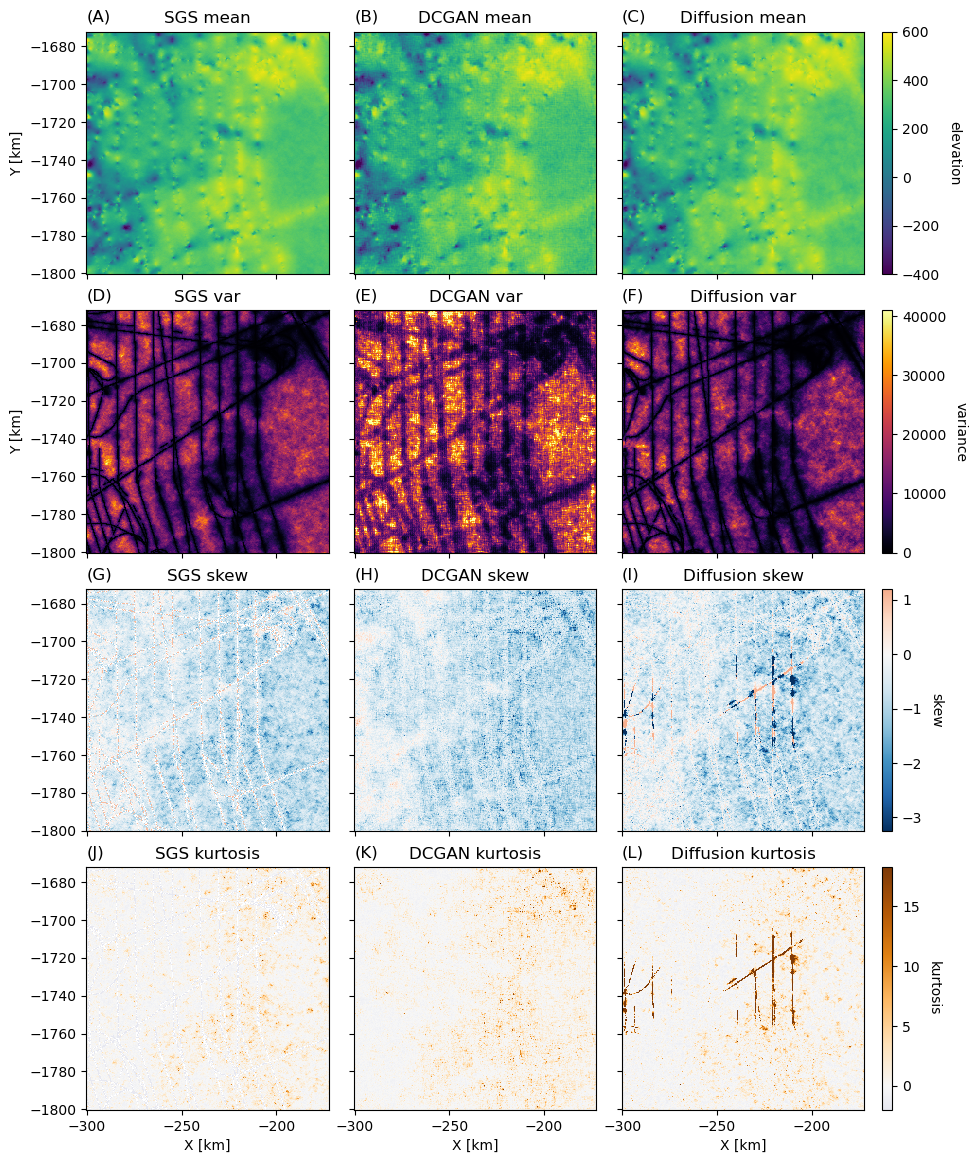

In [20]:
plots = [
    sgs_mean,
    dcgan_mean,
    diff_mean,
    sgs_var,
    dcgan_var,
    diff_var,
    skew(sgs, axis=0),
    skew(dcgan, axis=0),
    skew(diffusion, axis=0),
    kurtosis(sgs, axis=0),
    kurtosis(dcgan, axis=0),
    kurtosis(diffusion, axis=0)
]

titles = [
    'SGS mean',
    'DCGAN mean',
    'Diffusion mean',
    'SGS var',
    'DCGAN var',
    'Diffusion var',
    'SGS skew',
    'DCGAN skew',
    'Diffusion skew',
    'SGS kurtosis',
    'DCGAN kurtosis',
    'Diffusion kurtosis'
]

var_vmax = np.nanmax(np.var(sgs, axis=0))
skew_vmax = np.nanmax(skew(sgs, axis=0))
skew_vmin = np.nanmin(skew(sgs, axis=0))
kurt_vmax = np.nanmax(kurtosis(sgs, axis=0))
kurt_vmin = np.nanmin(kurtosis(sgs, axis=0))

skew_norm = colors.TwoSlopeNorm(vmin=skew_vmin, vcenter=0., vmax=skew_vmax)
kurt_norm = colors.TwoSlopeNorm(vmin=kurt_vmin, vcenter=0., vmax=kurt_vmax)

skew_cmap = cmocean.tools.crop(plt.cm.RdBu_r, skew_vmin, skew_vmax, 0)
kurt_cmap = cmocean.tools.crop(plt.cm.PuOr_r, kurt_vmin, kurt_vmax, 0)

fig = plt.figure(figsize=(10.5,14))
spec = GridSpec(ncols=4, nrows=4, figure=fig, width_ratios=[1, 1, 1, 0.04], hspace=0.15, wspace=0.05)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[0, 2])
ax4 = fig.add_subplot(spec[1, 0])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[1, 2])
ax7 = fig.add_subplot(spec[2, 0])
ax8 = fig.add_subplot(spec[2, 1])
ax9 = fig.add_subplot(spec[2, 2])
ax10 = fig.add_subplot(spec[3, 0])
ax11 = fig.add_subplot(spec[3, 1])
ax12 = fig.add_subplot(spec[3, 2])
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]

for i, (ax, plot, title) in enumerate(zip(axs, plots, titles)):
    if i < 3:
        im1 = ax.pcolormesh(xx/1000, yy/1000, plot, vmin=-400, vmax=600, cmap='viridis')
    elif i < 6:
        im2 = ax.pcolormesh(xx/1000, yy/1000, plot, vmin=0, vmax=var_vmax, cmap='inferno')
    elif i < 9:
        im3 = ax.pcolormesh(xx/1000, yy/1000, plot, vmin=skew_vmin, vmax=skew_vmax, cmap=skew_cmap)
    else:
        im4 = ax.pcolormesh(xx/1000, yy/1000, plot, vmin=kurt_vmin, vmax=kurt_vmax, cmap=kurt_cmap)
        ax.set_xlabel('X [km]')
    ax.set_title(title)
    ax.axis('scaled')

ax1.set_ylabel('Y [km]')
ax4.set_ylabel('Y [km]')

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]:
    ax.set_xticklabels([])
for ax in [ax2, ax3, ax5, ax6, ax8, ax9, ax11, ax12]:
    ax.set_yticklabels([])

cax = fig.add_subplot(spec[0, 3])
cbar = plt.colorbar(im1, cax=cax)
cbar.set_label('elevation', rotation=270, labelpad=15)

cax = fig.add_subplot(spec[1, 3])
cbar = plt.colorbar(im2, cax=cax)
cbar.set_label('variance', rotation=270, labelpad=15)

cax = fig.add_subplot(spec[2, 3])
cbar = plt.colorbar(im3, cax=cax)
cbar.set_label('skew', rotation=270, labelpad=15)

cax = fig.add_subplot(spec[3, 3])
cbar = plt.colorbar(im4, cax=cax)
cbar.set_label('kurtosis', rotation=270, labelpad=15)

labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)', '(G)', '(H)', '(I)', '(J)', '(K)', '(L)']

for ax, label in zip([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12], labels):
    ax.text(-0.0, 1.09, label, color='k', fontsize=12, ha='left', va='top', transform=ax.transAxes)

plt.savefig('Plots/mean_var_skew_kurt_grid.png', dpi=300, bbox_inches='tight')
plt.show()

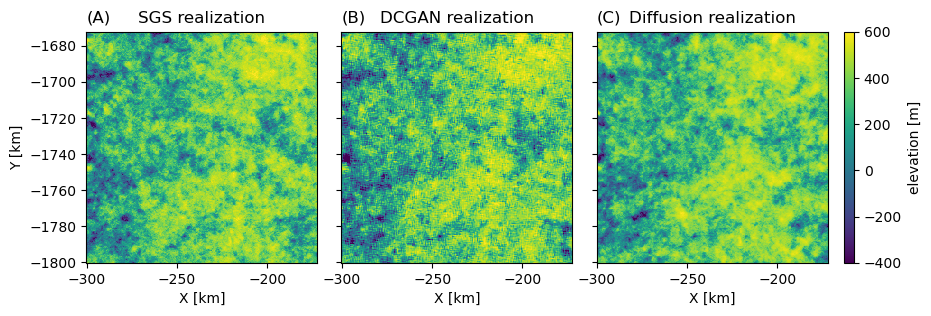

In [34]:
fig = plt.figure(figsize=(10, 3))
spec = GridSpec(ncols=4, nrows=1, figure=fig, width_ratios=[1, 1, 1, 0.04], wspace=0.05)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[0, 2])
cax = fig.add_subplot(spec[0, 3])

ax = ax1
ax.pcolormesh(xx/1000, yy/1000, sgs[0], vmin=-400, vmax=600)
ax.axis('scaled')
ax.set_title('SGS realization')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')

ax = ax2
ax.pcolormesh(xx/1000, yy/1000, dcgan[0], vmin=-400, vmax=600)
ax.axis('scaled')
ax.set_title('DCGAN realization')
ax.set_xlabel('X [km]')
ax.set_yticklabels([])

ax = ax3
im = ax.pcolormesh(xx/1000, yy/1000, diffusion[0], vmin=-400, vmax=600)
ax.axis('scaled')
ax.set_title('Diffusion realization')
ax.set_xlabel('X [km]')
ax.set_yticklabels([])

plt.colorbar(im, cax=cax, label='elevation [m]')

labels = ['(A)', '(B)', '(C)']

for ax, label in zip([ax1, ax2, ax3], labels):
    ax.text(-0.0, 1.094, label, color='k', fontsize=12, ha='left', va='top', transform=ax.transAxes)

plt.savefig('Plots/realizations.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
plots = [
    dcgan_mean - sgs_mean,
    diff_mean - sgs_mean,
    dcgan_var - sgs_var,
    diff_var - sgs_var
]

dmean_vmax = np.max(np.abs(np.array([plots[0], plots[1]])))
dvar_vmax = np.max(np.abs(np.array([plots[2], plots[3]])))

titles = [
    'DCGAN mean error',
    'Diffusion mean error',
    'DCGAN variance error',
    'Diffusion variance error'
]

fig = plt.figure(figsize=(8.5, 8))
spec = GridSpec(ncols=3, nrows=2, figure=fig, width_ratios=[1, 1, 0.04], wspace=0.05)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])

for i, (ax, plot, title) in enumerate(zip([ax1, ax2, ax3, ax4], plots, titles)):
    if i<2:
        im1 = ax.pcolormesh(xx/1000, yy/1000, plot, cmap='RdBu_r', vmin=-dmean_vmax, vmax=dmean_vmax)
    else:
        im2 = ax.pcolormesh(xx/1000, yy/1000, plot, cmap='RdBu_r', vmin=-20e3, vmax=20e3)
    ax.axis('scaled')
    ax.set_title(title)
        
for ax in [ax1, ax3]:
    ax.set_ylabel('Y [km]')

for ax in [ax2, ax4]:
    ax.set_yticklabels([])

for ax in [ax3, ax4]:
    ax.set_xlabel('X [km]')

cax = fig.add_subplot(spec[0, 2])
cbar = plt.colorbar(im1, cax=cax)
cbar.set_label('difference [m]', rotation=270, labelpad=15)

cax = fig.add_subplot(spec[1, 2])
cbar = plt.colorbar(im2, cax=cax, extend='both')
cbar.set_label(r'difference [m$^2$]', rotation=270, labelpad=15)

labels = ['(A)', '(B)', '(C)', '(D)']

for ax, label in zip([ax1, ax2, ax3, ax4], labels):
    ax.text(-0.0, 1.075, label, color='k', fontsize=12, ha='left', va='top', transform=ax.transAxes)

plt.savefig('Plots/mean_var_error.png', dpi=300, bbox_inches='tight')
plt.show()